In [1]:
!pip install torchio

     |████████████████████████████████| 112 kB 3.2 MB/s eta 0:00:01
     |████████████████████████████████| 42.5 MB 143 kB/s  eta 0:00:01    |▍                               | 522 kB 12.4 MB/s eta 0:00:04     |██████▊                         | 9.0 MB 12.4 MB/s eta 0:00:03
     |████████████████████████████████| 3.3 MB 64.3 MB/s eta 0:00:01     |███████████████████▉            | 2.1 MB 64.3 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 23.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 42.0 MB/s eta 0:00:01
  Created wheel for Python-Deprecated: filename=Python_Deprecated-1.1.0-py2.py3-none-any.whl size=3069 sha256=16d0fe9de719c9952339a7797601fa24e228387f865322ad08ccd9594feb7b0d
  Stored in directory: /root/.cache/pip/wheels/7b/77/f4/889fb222210030f42875d19bb55b64ea2b394428066fd3a6f4
Successfully built Python-Deprecated


In [2]:
import gc
gc.collect()

185

In [2]:
!pip install monai

     |████████████████████████████████| 298 kB 3.2 MB/s eta 0:00:01


In [8]:
!conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
absl-py                   0.10.0                   pypi_0    pypi
alabaster                 0.7.12                   pypi_0    pypi
apex                      0.1                      pypi_0    pypi
argon2-cffi               20.1.0                   pypi_0    pypi
ascii-graph               1.5.1                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
async-generator           1.10                     pypi_0    pypi
attrs                     20.2.0                     py_0  
audioread                 2.1.9                    pypi_0    pypi
babel                     2.8.0                    pypi_0    pypi
backcall                  0.2.0                      py_0  
beautifulsoup4            4.9.3              pyhb0f4dca_0  
blas                      1.0                    openbla

In [3]:
!pip install itk

     |████████████████████████████████| 36.3 MB 335 kB/s eta 0:00:01    |████▎                           | 4.9 MB 4.3 MB/s eta 0:00:08     |█████████████████████████████▉  | 33.9 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 71.0 MB/s eta 0:00:01
     |████████████████████████████████| 14.4 MB 52.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.0 MB 76.3 MB/s eta 0:00:01
     |████████████████████████████████| 50.1 MB 65.0 MB/s eta 0:00:01
     |████████████████████████████████| 68.0 MB 176 kB/s  eta 0:00:01     |█████████▍                      | 20.0 MB 77.5 MB/s eta 0:00:01


In [23]:
import argparse
import os
import sys
import pandas as pd
from tqdm import tqdm
import numpy as np
import glob
import multiprocessing

import torch
import torch.optim as optim
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter
from torch import autograd

from torchio.transforms import CropOrPad
from monai.data import ArrayDataset, DataLoader, PILReader
from monai.transforms import Compose, LoadImage, AddChannel, RandFlip, RandRotate, RandRotate90, RandScaleIntensity, CenterSpatialCrop, ToTensor, ScaleIntensity, LoadPNG, RandSpatialCrop
from monai.visualize import plot_2d_or_3d_image

import FlowArrayDataset
import FlowPatchArrayDataset

from utils import *
from VGGLoss import *
from Generator import *
from Discriminator import *

In [2]:
# Replace with variables - no commandline arguments in notebook
parser = argparse.ArgumentParser(description='Train')
parser.add_argument('--num_epochs_G', default=3, type=int,
                    help='number of epochs to pre-train generator, otherwise set to None')
parser.add_argument('--num_epochs', default=3, type=int, help='number of epochs')
parser.add_argument('--batch_size', default=2, type=int, help='batch size')
parser.add_argument('--mode', default='MSE', type=str,
                    help='MSE for MSE as a content loss or VGG for pretrained vgg19 as a content loss')
parser.add_argument('--aug_prob', default=15, type=int, help='augmentation probability')
parser.add_argument('--data_dir', default='./images/*/*', type=str) #'./images/*/*'
parser.add_argument('--load_weight_dir', default=None, type=str,
                    help='if you want to continue training load the checkpoint, otherwise set to None')
parser.add_argument('--save_weight_dir', default='./checkpoints/tempcheckpoint',
                    type=str, help='directory where training weightes are saved')
parser.add_argument('--log_dir', default='./logs/templog',
                    type=str, help='directory where tensorboard logs are saved')
parser.add_argument('--save_loss_dir', default='./lossinfo/templossinfo',
                    type=str, help='directory for loss information')

_StoreAction(option_strings=['--save_loss_dir'], dest='save_loss_dir', nargs=None, const=None, default='./lossinfo/templossinfo', type=<class 'str'>, choices=None, help='directory for loss information', metavar=None)

In [24]:
num_epochs_G = 10
num_epochs = 600
batch_size = 8
mode = "VGG"
adv_weight = 1e-2
aug_prob = 30
data_dir = "/data/*"
load_weight_dir = None #"checkpoints/tempcheckpoint/pretrained_G_epoch_100.pth"
save_weight_dir = "checkpoints/tempcheckpoint2"
log_dir = "logs/templog2"
loss_dir = "lossinfo/templossinfo2"

In [25]:
if not os.path.exists(save_weight_dir):
    os.makedirs(save_weight_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(loss_dir):
    os.makedirs(loss_dir)

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(f'using GPU? : {torch.cuda.is_available()}, GPU: {torch.cuda.get_device_name()}', )
#writer = SummaryWriter(log_dir=log_dir)  # tensorboard

using GPU? : True, GPU: A100-SXM4-40GB


In [27]:
# 6 input slices
inputZ01_path = sorted(glob.glob(os.path.join(data_dir, '*A04Z01*.tif'), recursive=True))
inputZ02_path = sorted(glob.glob(os.path.join(data_dir, '*A04Z02*.tif'), recursive=True))
inputZ03_path = sorted(glob.glob(os.path.join(data_dir, '*A04Z03*.tif'), recursive=True))
inputZ04_path = sorted(glob.glob(os.path.join(data_dir, '*A04Z04*.tif'), recursive=True))
inputZ05_path = sorted(glob.glob(os.path.join(data_dir, '*A04Z05*.tif'), recursive=True))
inputZ06_path = sorted(glob.glob(os.path.join(data_dir, '*A04Z06*.tif'), recursive=True))
inputZ07_path = sorted(glob.glob(os.path.join(data_dir, '*A04Z07*.tif'), recursive=True))

# 3 output channels
targetC01_path = sorted(glob.glob(os.path.join(data_dir, '*C01.tif'), recursive=True))
targetC02_path = sorted(glob.glob(os.path.join(data_dir, '*C02.tif'), recursive=True))
targetC03_path = sorted(glob.glob(os.path.join(data_dir, '*C03.tif'), recursive=True))

# split training/validation
inputZ01, inputZ01_val = split_train_val(inputZ01_path)
inputZ02, inputZ02_val = split_train_val(inputZ02_path)
inputZ03, inputZ03_val = split_train_val(inputZ03_path)
inputZ04, inputZ04_val = split_train_val(inputZ04_path)
inputZ05, inputZ05_val = split_train_val(inputZ05_path)
inputZ06, inputZ06_val = split_train_val(inputZ06_path)
inputZ07, inputZ07_val = split_train_val(inputZ07_path)

targetC01, targetC01_val = split_train_val(targetC01_path)
targetC02, targetC02_val = split_train_val(targetC02_path)
targetC03, targetC03_val = split_train_val(targetC03_path)

In [91]:
def find_first_occurance(tuple_list, target_str):
    for i, t in enumerate(tuple_list):
        if target_str in t[0]:
            return i
        
def split_train_val(data_list, N_valid_per_magn=1):
    indexes = [
        find_first_occurance(data_list, mag_lev)
        for mag_lev in ["20x", "40x", "60x"]
    ]
    indexes = [i for initial in indexes for i in range(initial, initial+N_valid_per_magn)]
    train_split = [data_list[i] for i in range(len(data_list)) if i not in indexes]
    val_split = [data_list[i] for i in indexes]
    return train_split, val_split

In [70]:
# collect instances
inputs = [
    sorted(glob.glob(os.path.join(data_dir, f'*A04Z0{i}*.tif'), recursive=True))
    for i in range(1,8)
]
targets = [
    sorted(glob.glob(os.path.join(data_dir, f'*C0{i}.tif'), recursive=True))
    for i in range(1,4)
]
# merge inputs and targets
all_data = inputs + targets
# match the slices and match all of the data for one input instance
data_all_ch = list(zip(*all_data))
data_all_ch[0]

('/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z02C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z03C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z04C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z05C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z06C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z07C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A02Z01C02.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A03Z01C03.tif')

In [97]:
train_split, val_split = split_train_val(data_all_ch, 
                                         N_valid_per_magn=2)

In [87]:
indexes = [
        find_first_occurance(data_all_ch, mag_lev)
        for mag_lev in ["20x", "40x", "60x"]
    ]
indexes = [i for initial in indexes for i in range(initial, initial+4)]
indexes

[0, 1, 2, 3, 48, 49, 50, 51, 112, 113, 114, 115]

In [36]:
inputZ01_path[111:114]

['/data/40x_images/AssayPlate_Greiner_#655090_D04_T0001F008L01A04Z01C04.tif',
 '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif',
 '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z01C04.tif']

In [37]:
inputZ01_path[112]

'/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif'

In [38]:
asd = inputZ01_path.pop(112)

In [39]:
inputZ01_path[112]

'/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z01C04.tif'

In [40]:
inputZ01_path[111:114]

['/data/40x_images/AssayPlate_Greiner_#655090_D04_T0001F008L01A04Z01C04.tif',
 '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z01C04.tif',
 '/data/60x_images/AssayPlate_Greiner_#655090_B03_T0001F003L01A04Z01C04.tif']

In [7]:
# data preprocessing/augmentation
trans_train = TrainCompose(
        [
            LoadImage(PILReader(), image_only=True),
            #ScaleIntensity(),
            AddChannel(),
            RandSpatialCrop(roi_size=256, random_size=False),
            #CenterSpatialCrop(roi_size=2154),  # 2154
            RandScaleIntensity(factors=0.25, prob=aug_prob),
            #RandRotate(range_x=15, prob=aug_prob, keep_size=True),
            RandRotate90(prob=aug_prob, spatial_axes=(0, 1)),
            RandFlip(spatial_axis=0, prob=aug_prob),
            ToTensor()
        ]
    )

trans_val = ValCompose(
    [
        LoadImage(PILReader(), image_only=True),
        #ScaleIntensity(),
        AddChannel(),
        RandSpatialCrop(roi_size=256, random_size=False),
        #CenterSpatialCrop(roi_size=2154),
        ToTensor()
    ]
)
# create dataset class
train_dataset = FlowArrayDataset.FlowArrayDataset(
    inputZ01=inputZ01, inputZ01_transform=trans_train,
    inputZ02=inputZ02, inputZ02_transform=trans_train,
    inputZ03=inputZ03, inputZ03_transform=trans_train,
    inputZ04=inputZ04, inputZ04_transform=trans_train,
    inputZ05=inputZ05, inputZ05_transform=trans_train,
    inputZ06=inputZ06, inputZ06_transform=trans_train,
    inputZ07=inputZ07, inputZ07_transform=trans_train,
    targetC01=targetC01, targetC01_transform=trans_train,
    targetC02=targetC02, targetC02_transform=trans_train,
    targetC03=targetC03, targetC03_transform=trans_train,
    #roi_size=256, n_samples=8
)

val_dataset = FlowArrayDataset.FlowArrayDataset(
    inputZ01=inputZ01_val, inputZ01_transform=trans_val,
    inputZ02=inputZ02_val, inputZ02_transform=trans_val,
    inputZ03=inputZ03_val, inputZ03_transform=trans_val,
    inputZ04=inputZ04_val, inputZ04_transform=trans_val,
    inputZ05=inputZ05_val, inputZ05_transform=trans_val,
    inputZ06=inputZ06_val, inputZ06_transform=trans_val,
    inputZ07=inputZ07_val, inputZ07_transform=trans_val,
    targetC01=targetC01_val, targetC01_transform=trans_val,
    targetC02=targetC02_val, targetC02_transform=trans_val,
    targetC03=targetC03_val, targetC03_transform=trans_val,
    #roi_size=256, n_samples=8
)

In [8]:
training_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False
    #num_workers=4 #multiprocessing.cpu_count(),
)

validation_loader = DataLoader(
    val_dataset,
    batch_size=batch_size
    #num_workers=4 #multiprocessing.cpu_count(),
)

In [9]:
from monai.utils import first
import matplotlib.pyplot as plt

In [10]:
loader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
check_data = first(loader)
data_1 = check_data

Here
Here
Here
Here
Here
Here
Here
Here
Here
Here


In [49]:
inputZ01_path

['/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F003L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F004L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F005L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B03_T0001F006L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B04_T0001F001L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B04_T0001F002L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B04_T0001F003L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B04_T0001F004L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B04_T0001F005L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_B04_T0001F006L01A04Z01C04.tif',
 '/data/20x_images/AssayPlate_Greiner_#655090_C02_T0001F001L01A0

In [11]:
data_1[0].shape

torch.Size([1, 1, 256, 256])

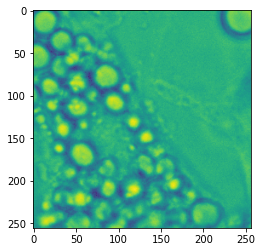

In [22]:
plt.imshow(data_1[0][0,0,:,:])

In [12]:
# load model / criterion / optimizer
netG = GeneratorUnet().to(device)
# print(netG)
netD = Discriminator().to(device)

In [13]:
mseloss = nn.MSELoss()
bceloss = nn.BCELoss()
#vggloss = VGGLoss()

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

In [15]:
# load weight if load_weight_dir is defined

if load_weight_dir is not None:
    
    path_to_saved_weight = os.path.join(load_weight_dir)
    checkpoint = torch.load(path_to_saved_weight)  # when you are loading weights saved on gpu device
    netG.load_state_dict(checkpoint['model_state_dict'])
    print(f'Loading checkpoint: {load_weight_dir}')
    # path_to_saved_weight = os.path.join(load_weight_dir)
    #checkpoint = torch.load(load_weight_dir) 
    #netG.load_state_dict(checkpoint['model_state_dict'])
    
    #checkpoint = torch.load(load_weight_dir)
    #netG.load_state_dict(checkpoint['model_state_dict'])
    #optimizerG.load_state_dict(checkpoint['optimizer_state_dict'])
    #init_epoch = checkpoint['epoch']
    #loss = checkpoint['loss']
else:
    init_epoch = 0
    
print(f'Loading checkpoint: {load_weight_dir}')
path_to_saved_weight = os.path.join(load_weight_dir)
checkpoint = torch.load(path_to_saved_weight)  # when you are loading weights saved on gpu device
netG.load_state_dict(checkpoint['model_state_dict'])

Loading checkpoint: None


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [14]:
if num_epochs_G is not None:
    print(f'pre-training Generator for {num_epochs_G} epochs')
    save_gene = pd.DataFrame(columns=['TotalLoss', 'lossC01', 'lossC02', 'lossC03'])

    for epoch in range(1, num_epochs_G + 1):
        pretrainedG_losses = []
        lossC01s = []
        lossC02s = []
        lossC03s = []

        netG.train()

        for batch_index, batch in enumerate(tqdm(training_loader)):
            inputZ01, inputZ02, inputZ03, inputZ04, inputZ05, inputZ06, inputZ07 = \
                batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                batch[3].to(device), batch[4].to(device), batch[5].to(device), batch[6].to(device)
            targetC01, targetC02, targetC03 = batch[7].to(device), batch[8].to(device), batch[9].to(device)

#             print('input size :' + str(inputZ01.size()))
#             print('target size :' + str(targetC01.size()))

            netG.zero_grad()

            outputC01, outputC02, outputC03 = netG(inputZ01, inputZ02, inputZ03, inputZ04, inputZ05, inputZ06, inputZ07)

            # with autograd.detect_anomaly():
            loss01 = mseloss(outputC01, targetC01)
            loss02 = mseloss(outputC01, targetC01)
            loss03 = mseloss(outputC01, targetC01)

            loss_gene = loss01 + loss02 + loss03
            loss_gene.backward()
            optimizerG.step()

            pretrainedG_losses.append(loss_gene.detach().item())
            lossC01s.append(loss01.detach().item())
            lossC02s.append(loss02.detach().item())
            lossC03s.append(loss03.detach().item())

        epoch_loss = np.array(pretrainedG_losses).mean()
        epoch_lossC01 = np.array(lossC01s).mean()
        epoch_lossC02 = np.array(lossC02s).mean()
        epoch_lossC03 = np.array(lossC03s).mean()

        print(f'Pre-training Generator - Epoch {epoch}/{num_epochs} loss: {epoch_loss}, loss01: {epoch_lossC01}, loss02: {epoch_lossC02}, loss03: {epoch_lossC03}')
        save_gene = save_gene.append({'TotalLoss': epoch_loss, 'lossC01': epoch_lossC01, 'lossC02': epoch_lossC02, 'lossC03': epoch_lossC03}, ignore_index=True)
        save_gene.to_csv(os.path.join(loss_dir, 'generator_loss_info.csv'))

        # save model parameters
        weight = f'pretrained_G_epoch_{epoch}.pth'
        torch.save(netG.state_dict(), os.path.join(save_weight_dir, weight))
        torch.save({'epoch': epoch,
                    'model_state_dict': netG.state_dict(),
                    'optimizer_state_dict': optimizerG.state_dict(),
                    'loss': epoch_loss}, os.path.join(save_weight_dir, weight))

  0%|          | 0/145 [00:00<?, ?it/s]

pre-training Generator for 10 epochs


  4%|▍         | 6/145 [00:46<17:38,  7.61s/it]

KeyboardInterrupt: 

In [ ]:
if num_epochs_G is not None:
    print(f'Loading weights from pretrained generator')
    finalweight = f'pretrained_G_epoch_{num_epochs_G}.pth'
    checkpoint = torch.load(os.path.join(save_weight_dir, finalweight))
    netG.load_state_dict(checkpoint['model_state_dict'])
    optimizerG.load_state_dict(checkpoint['optimizer_state_dict'])
    init_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
else:
    pass


if num_epochs_G is not None:
    init_epoch = num_epochs_G + 1
    num_epochs = num_epochs + num_epochs_G
else:
    num_epochs = num_epochs
    
    if load_weight_dir is None:
        init_epoch = 1
    else:
        init_epoch = init_epoch
        num_epochs = num_epochs + init_epoch



In [ ]:
save_gan_train = pd.DataFrame(columns=['TotalLoss', 'lossC01', 'lossC02', 'lossC03'])
save_gan_val = pd.DataFrame(columns=['TotalLoss', 'lossC01', 'lossC02', 'lossC03'])

In [ ]:
%tensorboard --logdir {log_dir}

In [ ]:
for epoch in range(init_epoch, num_epochs + 1):
    print(f'Epoch : [{epoch} / {num_epochs}]')
    netG.train()
    G_losses = []
    D_losses = []

    lossC01s = []
    lossC02s = []
    lossC03s = []

    for batch_index, batch in enumerate(tqdm(training_loader)):
        inputZ01, inputZ02, inputZ03, inputZ04, inputZ05, inputZ06, inputZ07 = \
            batch[0].to(device), batch[1].to(device), batch[2].to(device),\
            batch[3].to(device), batch[4].to(device), batch[5].to(device), batch[6].to(device)
        targetC01, targetC02, targetC03 = batch[7].to(device), batch[8].to(device), batch[9].to(device)
        
        shape = inputZ01.size()
        real_label = torch.ones((shape[0])).to(device)
        fake_label = torch.zeros((shape[0])).to(device)

        ###############################################################
        # First train discriminator network : maximize D(x)-1-D(G(z)) #
        ###############################################################

        netD.zero_grad()
        
        outputC01, outputC02, outputC03 = netG(inputZ01, inputZ02, inputZ03, inputZ04, inputZ05, inputZ06, inputZ07)
        
        targetCs = torch.cat((targetC01, targetC02, targetC03), dim=1)
        realCs_prob = netD(targetCs)
        
        outputCs = torch.cat((outputC01, outputC02, outputC03), dim=1)
        fakeCs_prob = netD(outputCs)
        
        # print(realC01_prob.size())
        # print(real_label.size())
        
        d_loss_real = bceloss(realCs_prob, real_label)
        #bceloss(realC01_prob, real_label) + bceloss(realC02_prob, real_label) + bceloss(realC03_prob, real_label)
        d_loss_fake = bceloss(fakeCs_prob, fake_label)
        #bceloss(fakeC01_prob, fake_label) + bceloss(fakeC02_prob, fake_label) + bceloss(fakeC03_prob, fake_label)

        d_loss = d_loss_real + d_loss_fake

        d_loss.backward()
        optimizerD.step()

        D_losses.append(d_loss.item())

        #################################################################
        # Now train Generator network                                   #
        # option 1 (mode='MSE') : minimize mseloss + 10^-3 * -logD(G(z))#
        # option 2 (mode='VGG') : minimize vggloss + 10^-3 * -logD(G(z))#
        #################################################################
        netG.zero_grad()

        outputC01, outputC02, outputC03 = netG(inputZ01, inputZ02, inputZ03, inputZ04, inputZ05, inputZ06, inputZ07)

        if mode == 'MSE':
            lossC01 = mseloss(outputC01, targetC01)
            lossC02 = mseloss(outputC02, targetC02)
            lossC03 = mseloss(outputC03, targetC03)
            content_loss = lossC01 + lossC02 + lossC03

        if mode == 'VGG':
            lossC01 = vggloss(outputC01, targetC01)
            lossC02 = vggloss(outputC02, targetC02)
            lossC03 = vggloss(outputC03, targetC03)
            content_loss = lossC01 + lossC02 + lossC03
        
        outputCs = torch.cat((outputC01, outputC02, outputC03), dim=1)
        fakeCs_prob = netD(outputCs)
        
        adversarial_loss = bceloss(fakeCs_prob, real_label)

        # adversarial_loss = bceloss(netD(outputC01), real_label) + bceloss(netD(outputC02), real_label) + bceloss(netD(outputC03), real_label)
        # can try bce loss on bceloss(outputC1-3, targetC1-3)

        g_loss = content_loss + 1e-3 * adversarial_loss

        g_loss.backward()
        optimizerG.step()

        G_losses.append(g_loss.detach().item())
        lossC01s.append(lossC01.detach().item())
        lossC02s.append(lossC02.detach().item())
        lossC03s.append(lossC03.detach().item())


        # log to tensorboard every 10 steps
        if batch_index % 1 == 0:
            writer.add_scalar('Train/G_loss', g_loss.item(), epoch)
            writer.add_scalar('Train/D_loss', d_loss.item(), epoch)
            #plot_2d_or_3d_image(targetC01, epoch * len(training_loader) + batch_index, writer, index=0, tag="Groundtruth_train/C01")
            #plot_2d_or_3d_image(targetC02, epoch * len(training_loader) + batch_index, writer, index=0, tag="Groundtruth_train/C01")
            #plot_2d_or_3d_image(targetC03, epoch * len(training_loader) + batch_index, writer, index=0, tag="Groundtruth_train/C01")
            #plot_2d_or_3d_image(outputC01, epoch * len(training_loader) + batch_index, writer, index=0, tag="Train/C01")
            #plot_2d_or_3d_image(outputC02, epoch * len(training_loader) + batch_index, writer, index=0, tag="Train/C01")
            #plot_2d_or_3d_image(outputC03, epoch * len(training_loader) + batch_index, writer, index=0, tag="Train/C01")

    if epoch % 1 == 0:
        writer.add_images('Groundtruth_train/C01', targetC01, epoch)
        writer.add_images('Groundtruth_train/C02', targetC02, epoch)
        writer.add_images('Groundtruth_train/C03', targetC03, epoch)
        writer.add_images('train/C01', outputC01, epoch)
        writer.add_images('train/C02', outputC02, epoch)
        writer.add_images('train/C03', outputC03, epoch)
    
    G_loss = np.array(G_losses).mean()
    D_loss = np.array(D_losses).mean()
    epoch_lossC01 = np.array(lossC01s).mean()
    epoch_lossC02 = np.array(lossC02s).mean()
    epoch_lossC03 = np.array(lossC03s).mean()

    save_gan_train = save_gan_train.append(
        {'TotalLoss': G_loss, 'lossC01': epoch_lossC01, 'lossC02': epoch_lossC02, 'lossC03': epoch_lossC03},
        ignore_index=True)
    save_gan_train.to_csv(os.path.join(loss_dir, 'gan_train_loss_info.csv'))

    print(f'Epoch {epoch}/{num_epochs} Training g_loss : {G_loss}, d_loss : {D_loss}')

    ################################################################################################################
    # Validation
    netG.eval()

    val_G_losses = []
    val_lossC01s = []
    val_lossC02s = []
    val_lossC03s = []

    with torch.no_grad():
        val_bar = tqdm(validation_loader)
        for batch_index, batch in enumerate(tqdm(training_loader)):
            inputZ01, inputZ02, inputZ03, inputZ04, inputZ05, inputZ06, inputZ07 = \
                batch[0].to(device), batch[1].to(device), batch[2].to(device), \
                batch[3].to(device), batch[4].to(device), batch[5].to(device), batch[6].to(device)
            targetC01, targetC02, targetC03 = batch[7].to(device), batch[8].to(device), batch[9].to(device)
            
            shape = inputZ01.size()
            real_label = torch.ones((shape[0])).to(device)
            fake_label = torch.zeros((shape[0])).to(device)

            outputC01, outputC02, outputC03 = netG(inputZ01, inputZ02, inputZ03, inputZ04, inputZ05, inputZ06, inputZ07)

            if mode == 'MSE':
                lossC01 = mseloss(outputC01, targetC01)
                lossC02 = mseloss(outputC02, targetC02)
                lossC03 = mseloss(outputC03, targetC03)
                content_loss = lossC01 + lossC02 + lossC03

            if mode == 'VGG':
                lossC01 = vggloss(outputC01, targetC01)
                lossC02 = vggloss(outputC02, targetC02)
                lossC03 = vggloss(outputC03, targetC03)
                content_loss = lossC01 + lossC02 + lossC03
            
            outputCs = torch.cat((outputC01, outputC02, outputC03), dim=1)
            fakeCs_prob = netD(outputCs)
            
            adversarial_loss = bceloss(fakeCs_prob, real_label)
            
            # adversarial_loss = bceloss(netD(outputC01), real_label) + bceloss(netD(outputC02), real_label) + bceloss(netD(outputC03), real_label)

            val_g_loss = content_loss + 1e-3 * adversarial_loss

            val_G_losses.append(val_g_loss.detach().item())
            val_lossC01s.append(lossC01.detach().item())
            val_lossC02s.append(lossC02.detach().item())
            val_lossC03s.append(lossC03.detach().item())


            # log to tensorboard every 10 steps
            if batch_index % 1 == 0:
                writer.add_scalar('Train/G_loss', val_g_loss.item(), epoch)
                #plot_2d_or_3d_image(targetC01, epoch * len(training_loader) + batch_index, writer, index=0, tag="Groundtruth_val/C01")
                #plot_2d_or_3d_image(targetC02, epoch * len(training_loader) + batch_index, writer, index=0, tag="Groundtruth_val/C01")
                #plot_2d_or_3d_image(targetC03, epoch * len(training_loader) + batch_index, writer, index=0, tag="Groundtruth_val/C01")
                #plot_2d_or_3d_image(outputC01, epoch * len(training_loader) + batch_index, writer, index=0, tag="Val/C01")
                #plot_2d_or_3d_image(outputC02, epoch * len(training_loader) + batch_index, writer, index=0, tag="Val/C01")
                #plot_2d_or_3d_image(outputC03, epoch * len(training_loader) + batch_index, writer, index=0, tag="Val/C01")

    if epoch % 1 == 0:
            writer.add_images('Groundtruth_val/C01', targetC01, epoch)
            writer.add_images('Groundtruth_val/C02', targetC02, epoch)
            writer.add_images('Groundtruth_val/C03', targetC03, epoch)
            writer.add_images('val/C01', outputC01, epoch)
            writer.add_images('val/C02', outputC02, epoch)
            writer.add_images('val/C03', outputC03, epoch)
    
    val_G_loss = np.array(val_G_losses).mean()
    val_epoch_lossC01 = np.array(val_lossC01s).mean()
    val_epoch_lossC02 = np.array(val_lossC02s).mean()
    val_epoch_lossC03 = np.array(val_lossC03s).mean()

    save_gan_val = save_gan_val.append(
        {'TotalLoss': val_G_loss, 'lossC01': val_epoch_lossC01, 'lossC02': val_epoch_lossC02, 'lossC03': val_epoch_lossC03},
        ignore_index=True)
    save_gan_val.to_csv(os.path.join(loss_dir, 'gan_val_loss_info.csv'))

    print(f'Epoch {epoch}/{num_epochs} Validation g_loss : {val_G_loss}')

    # now save model parameter (from training)
    weight_g = f'G_epoch_{epoch}.pth'
    torch.save({'epoch': epoch,
                'model_state_dict': netG.state_dict(),
                'optimizer_state_dict': optimizerG.state_dict(),
                'loss': G_loss}, os.path.join(save_weight_dir, weight_g))